<a href="https://colab.research.google.com/github/MAI3003-Data-Witches/Data-Witches_Project2/blob/main/MAI3003_DataWitches_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Witches**

| **Name**         | **Student ID** |
|------------------|----------------|
| Claessen, VVHJAE | i6339543       |
| Ovsiannikova, AM | i6365923       |
| Pubben, J        | i6276134       |
| Roca Cugat, M    | i6351071       |
| Záboj, J         | i6337952       |

# **Logbook**

**Changes**
Also see Git Commit History.

| **Version** | **Changes**      | **Date** |
|-------------|------------------|----------|
| v0.0        | Dataset loaded, EDA, cleaning   | 18-11-25 |
| v1.1        | *** | XX-11-25 |
| v0.2        | ***  | XX-11-25 |


## Methods

Let's ensure we all use the same names for all components.  

| **Variable**                   | **Name**                   |
|-------------------------------|----------------------------|
| Raw ECG dataframe             | df                         |
| Label dataframe               | df_labels                  |
| HRV features (train)          | hrv_train                  |
| HRV features (test)           | hrv_test                   |
|HRV extraction type           | FULL (nk.hrv — time + freq + nonlinear + RSA)|
| Clean HRV dataframe (train)   | hrv_train_clean            |
| Clean HRV dataframe (test)    | hrv_test_clean             |
| HRV + labels (train)          | hrv_train_with_labels      |
| Winsorized HRV column         | HRV_MedianNN_winsor       |
| Model feature matrix (train)  | X_train                    |
| Model feature matrix (test)   | X_test                     |
| Model target vector (train)   | y_train                    |
| Model target vector (test)    | y_test                     |


| **Function**              | **Description**                                | **Arguments**                                |
|---------------------------|------------------------------------------------|----------------------------------------------|
| corr_plot_hrv()           | Correlation plot for HRV features              | df, cols=None                                |
| distplots_hrv()           | Distribution plots (hist + KDE)                | df, cols=None                                |
| boxplots_hrv()            | Boxplots for selected HRV variables            | df, cols                                     |
| check_missing_hrv()       | Missingness summary                            | df                                           |
| identify_outliers()       | IQR-based outlier detection                    | df, column_name, threshold=1.5               |
| model_evaluation()        | Confusion matrix + classification report       | model                                        |
| model_desc()              | Accuracy, CV, ROC-AUC, model performance       | model                                        |


# Preface

## Packages imports

In [165]:
#!pip install -r requirements.txt

In [166]:
import sys
import random
import os.path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.signal import welch
import matplotlib.pyplot as plt
from joblib.testing import xfail
import plotly.graph_objects as go
from colorama import Fore, Back, Style
from plotly.subplots import make_subplots

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve

## Options settings

In [167]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
random.seed(3003)
IN_COLAB = 'google.colab' in sys.modules
DATA_PRESENT = os.path.isfile("data/Physionet2017Training.tar.xz")

## Dataset download

In [168]:
if not DATA_PRESENT:
    !mkdir data
    !wget https://github.com/MAI3003-Data-Witches/Data-Witches_Project2/raw/refs/heads/main/data/Physionet2017Training.tar.xz -O data/Physionet2017Training.tar.xz
    !tar -xf data/Physionet2017Training.tar.xz -C data
else: print("You already have the dataset downloaded, skipping")

You already have the dataset downloaded, skipping


In [169]:
df = pd.read_csv('data/Physionet2017TrainingData.csv', header=None, index_col=False) * 1000 # Load the dataset already in mV
#TODO: is it actually needed to convert to mV?

df.head()

0       1       2       3       4       5       6       7       8     \
0 -126000 -141000 -152000 -159000 -160000 -153000 -140000 -126000 -111000   
1   23000   25000   33000   61000   79000   85000   89000   93000   96000   
2 -116000 -146000 -174000 -190000 -199000 -207000 -211000 -211000 -207000   
3 -500000 -597000 -695000 -792000 -873000 -917000 -918000 -873000 -822000   
4  -74000  -96000 -118000 -141000 -153000 -162000 -169000 -174000 -177000   

     9       10      11      12      13      14      15      16      17    \
0  -93000  -72000  -46000  -17000       0   22000   55000   94000  123000   
1   98000   98000   99000  100000  100000  101000  101000  102000  102000   
2 -201000 -194000 -190000 -187000 -184000 -180000 -176000 -172000 -169000   
3 -767000 -751000 -740000 -730000 -722000 -715000 -709000 -703000 -698000   
4 -179000 -180000 -180000 -179000 -175000 -171000 -165000 -159000 -152000   

     18      19      20      21      22      23      24      25      26    \
0  145000  163000  169000  171000  171000  172000  172000  173000  174000   
1  102000  101000  102000  102000  103000  103000  103000  104000  106000   
2 -168000 -167000 -167000 -167000 -167000 -169000 -170000 -173000 -175000   
3 -695000 -693000 -691000 -690000 -689000 -687000 -685000 -683000 -682000   
4 -142000 -123000 -104000  -96000  -92000  -89000  -86000  -84000  -82000   

     27      28      29      30      31      32      33      34      35    \
0  173000  172000  172000  172000  171000  170000  169000  169000  170000   
1  108000  110000  111000  113000  115000  117000  118000  120000  121000   
2 -177000 -178000 -180000 -182000 -184000 -186000 -188000 -190000 -192000   
3 -681000 -680000 -680000 -681000 -684000 -688000 -695000 -701000 -706000   
4  -81000  -80000  -80000  -79000  -77000  -75000  -75000  -74000  -73000   

     36      37      38      39      40      41      42      43      44    \
0  169000  169000  171000  173000  176000  178000  181000  185000  191000   
1  124000  127000  131000  135000  139000  144000  147000  151000  155000   
2 -194000 -196000 -197000 -199000 -199000 -199000 -198000 -197000 -194000   
3 -713000 -720000 -727000 -733000 -737000 -740000 -743000 -747000 -753000   
4  -73000  -72000  -71000  -70000  -70000  -69000  -69000  -68000  -67000   

     45      46      47      48      49      50      51      52      53    \
0  203000  214000  227000  249000  277000  296000  312000  335000  367000   
1  160000  166000  173000  186000  199000  213000  229000  248000  267000   
2 -191000 -187000 -183000 -179000 -175000 -171000 -167000 -163000 -158000   
3 -762000 -768000 -772000 -774000 -776000 -778000 -780000 -777000 -769000   
4  -65000  -64000  -62000  -61000  -60000  -59000  -59000  -60000  -61000   

     54      55      56      57      58      59      60      61      62    \
0  402000  426000  444000  470000  494000  514000  528000  536000  543000   
1  276000  280000  284000  286000  288000  290000  292000  295000  297000   
2 -153000 -148000 -144000 -139000 -135000 -131000 -127000 -124000 -122000   
3 -758000 -746000 -731000 -722000 -715000 -710000 -706000 -703000 -701000   
4  -63000  -65000  -68000  -71000  -74000  -76000  -79000  -80000  -82000   

     63      64      65      66      67      68      69      70      71    \
0  549000  554000  556000  557000  555000  550000  544000  537000  531000   
1  300000  302000  305000  307000  311000  314000  318000  323000  334000   
2 -120000 -119000 -118000 -117000 -115000 -113000 -112000 -111000 -110000   
3 -699000 -697000 -693000 -689000 -684000 -680000 -677000 -674000 -670000   
4  -84000  -86000  -89000  -90000  -89000  -86000  -80000  -73000  -64000   

     72      73      74      75      76      77      78      79      80    \
0  528000  525000  521000  516000  512000  509000  505000  502000  498000   
1  345000  356000  361000  364000  367000  370000  373000  375000  376000   
2 -110000 -109000 -108000 -107000 -106000 -105000 -104000 -102000 -101

# Data preprocessing
## Extract ECG signals and class labels

In [170]:
df_labels = pd.read_csv('data/Physionet2017TrainingLabels.csv', header=None, names=['label'])
df_labels['classification'] = df_labels['label'].replace({"N": 0, "A": 1})
df_labels['label'] = df_labels['label'].replace({"N": 'Normal Sinus Rhythm', "A": 'Atrial Fibrillation'})
# 0: Normal Sinus Rhythm
# 1: Atrial Fibrillation

In [171]:
df_labels

,label,classification
0,Normal Sinus Rhythm,0
1,Normal Sinus Rhythm,0
2,Normal Sinus Rhythm,0
3,Normal Sinus Rhythm,0
4,Normal Sinus Rhythm,0
...,...,...
4519,Normal Sinus Rhythm,0
4520,Normal Sinus Rhythm,0
4521,Atrial Fibrillation,1
4522,Normal Sinus Rhythm,0


## Dataset splitting

In [172]:
df_labeled = pd.merge(df_labels.drop(columns='label'), df, left_on='classification', right_index=True)

train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df_labels["label"],
    random_state=3003
)

print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


# Functions Definitions

## Correlation plot

In [173]:
# Correlation plot
def corr_plot_hrv(df, cols=None):
    """
    Correlation heatmap for HRV features.
    """
    data = df[cols] if cols else df.select_dtypes("number")
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), cmap="coolwarm", center=0)
    plt.title("Correlation Map (HRV Features)")
    plt.show()

## Distribution plots

In [174]:
# Distribution plots
def distplots_hrv(df, cols=None):
    """
    Distribution plots (hist + KDE) for HRV features.
    """
    data = df[cols] if cols else df.select_dtypes("number")
    for col in data.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(data[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

def distplots(df):
    numeric_df = df.select_dtypes(include=['number'])
    num_features = len(numeric_df.columns)
    cols = int(np.ceil(np.sqrt(num_features)))
    rows = int(np.ceil(num_features / cols))

    # A figure with subplots looks much nicer
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(numeric_df.columns):
        # Technically not needed but might as well
        numeric_df_nona = numeric_df[column].dropna()

        axes[i].hist(numeric_df_nona, bins=30, alpha=0.7, edgecolor='black')

        if len(numeric_df_nona) > 1:
            density = stats.gaussian_kde(numeric_df_nona)
            xs = np.linspace(numeric_df_nona.min(), numeric_df_nona.max(), 200)
            axes[i].plot(xs, density(xs) * len(numeric_df_nona) * (numeric_df_nona.max() - numeric_df_nona.min()) / 30,
                         'r-', linewidth=2)

        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Number of Patients')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].grid(axis='y', alpha=0.3)

    # Remove any empty subplots if they exist
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Boxplots

In [175]:
# Boxplots
def boxplots_hrv(df, cols):
    """
    Boxplots for detecting unusual HRV values.
    """
    for col in cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

## Missingness overview

In [176]:
# Missingness
def check_missing_hrv(df):
    """
    Summarize missingness across HRV features.
    """
    missing = df.isna().sum()
    out = pd.DataFrame({
        "feature": df.columns,
        "missing_n": missing,
        "missing_%": (missing / len(df))*100
    })
    display(out.sort_values("missing_%", ascending=False))
    return out

# Exploratory Data Analysis
## Dataset characteristics

In [177]:
num_ecgs = len(df) # Number of ECGs

num_samples = df.shape[1] # Number of samples per ECG

sampling_frequency = 300#Hz
duration = num_samples / sampling_frequency # Duration of each ECG

class_distribution = df_labels['label'].value_counts() # Distribution over classes #TODO: quick pie chart?

print(f"Number of ECGs: {num_ecgs}")
print(f"Number of samples per ECG: {num_samples}")
print(f"Duration of each ECG: {duration} seconds")
print(f"\nClass Distribution:\n{class_distribution}")

Number of ECGs: 4524
Number of samples per ECG: 9000
Duration of each ECG: 30.0 seconds

Class Distribution:
label
Normal Sinus Rhythm    3950
Atrial Fibrillation     574
Name: count, dtype: int64


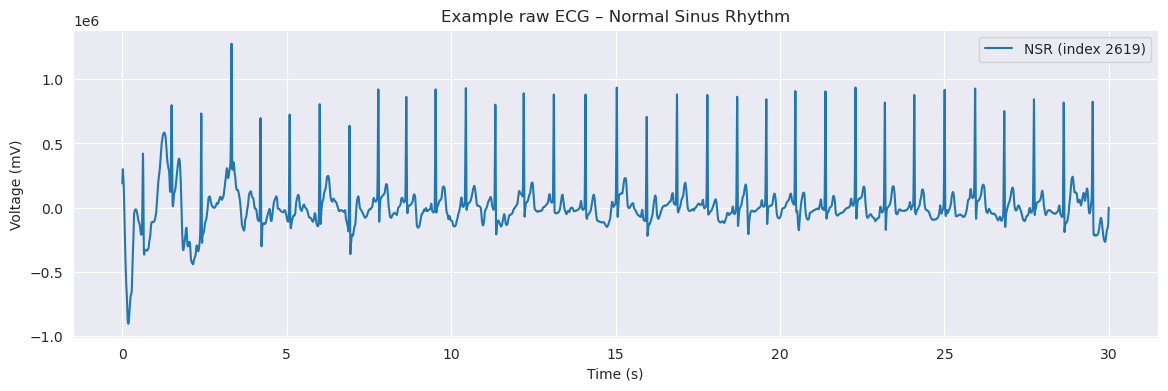

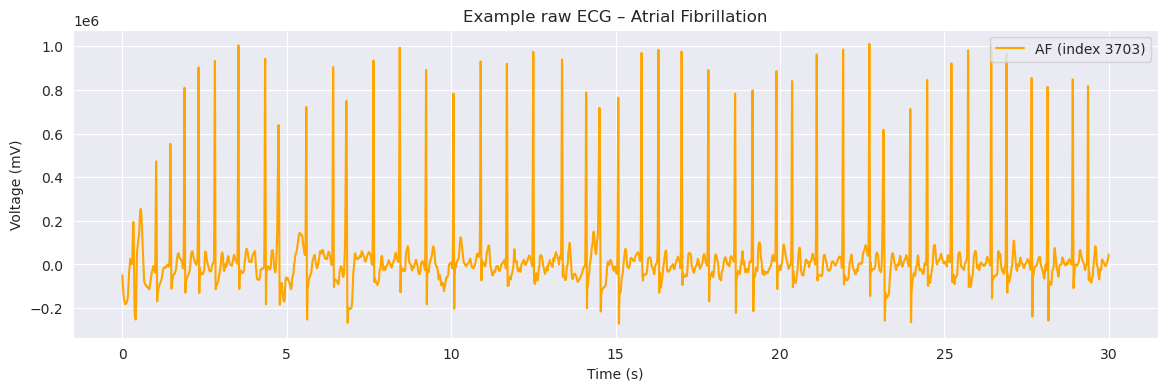

In [178]:
# Indices per class (based on df_labels)
sinus_indices = df_labels[df_labels["label"] == "Normal Sinus Rhythm"].index.tolist()
af_indices    = df_labels[df_labels["label"] == "Atrial Fibrillation"].index.tolist()

example_sinus_idx = random.choice(sinus_indices)
example_af_idx    = random.choice(af_indices)

ecg_sinus_raw = df.iloc[example_sinus_idx].astype(float).values
ecg_af_raw    = df.iloc[example_af_idx].astype(float).values

time = np.arange(0, len(ecg_sinus_raw)) / sampling_frequency

plt.figure(figsize=(14, 4))
plt.plot(time, ecg_sinus_raw, label=f"NSR (index {example_sinus_idx})")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Example raw ECG – Normal Sinus Rhythm")
plt.legend()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(time, ecg_af_raw, label=f"AF (index {example_af_idx})", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Example raw ECG – Atrial Fibrillation")
plt.legend()
plt.show()

In [179]:
# Summary statistics for each ECG
summary_stats = df.describe().T
summary_stats = pd.concat([summary_stats, df_labels], axis=1)

# Plotting the distributions of summary statistics
stats_to_plot = ['mean', 'std', 'min', 'max', '25%', '75%']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, stat in enumerate(stats_to_plot):
  sns.kdeplot(ax=axes[i], data=summary_stats, x=stat, hue='label', fill=True, common_norm=False)
  axes[i].set_title(f'Distribution of voltage {stat} by rhythm category')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
counts = df_labels.label.value_counts().tolist()

plt.figure(figsize=(6, 6))
plt.pie(counts, autopct='%1.1f%%', startangle=140)
plt.title('Rhythm Distribution')
plt.show()

## ECG exploration
Let's have a look at the ECG signals. The AliveCor ECGs are single lead ECGs, similar to **Lead I** in a standard 12-lead ECG. First, we determine which ECGs are in Normal Sinus Rhythm, and which ECGs are in Atrial Fibrillation

In [ ]:
# Randomly select ECGs from each class
number_of_selectedECGs = 1  # change to plot more ECGs for each rhythm category
selected_sinus_indices = random.sample(sinus_indices, number_of_selectedECGs)
selected_af_indices = random.sample(af_indices, number_of_selectedECGs)

# Create subplots
fig = make_subplots(rows=number_of_selectedECGs, cols=2, subplot_titles=("Normal Sinus Rhythm", "Atrial Fibrillation"))

# Plot NSR ECGs on the left subplot
for i, index in enumerate(selected_sinus_indices):
    time = np.arange(0, len(df.iloc[index])) / sampling_frequency  # Assuming sampling_frequency is defined
    fig.add_trace(go.Scatter(x=time, y=df.iloc[index], mode='lines', name=f'ECG {index + 1}'), row=i+1, col=1)

# Plot AF ECGs on the right subplot
for i, index in enumerate(selected_af_indices):
    time = np.arange(0, len(df.iloc[index])) / sampling_frequency  # Assuming sampling_frequency is defined
    fig.add_trace(go.Scatter(x=time, y=df.iloc[index], mode='lines', name=f'ECG {index + 1}'), row=i+1, col=2)

# Update layout
fig.update_layout(title_text="Selected ECGs: NSR vs. AF",
                  xaxis_title='Time (s)',
                  yaxis_title='Voltage (mV)',
                  showlegend=False,)

fig.show()

## ECG frequency analysis
An important feature of any signal is the frequency content: it tells us which frequency a predominantly present in the signal. In this case, differences in cardiac rhythm may be associated with differences in frequency content. The following code computes the frequency content of an ECG signal using the *Fourier transform* (`fft` in Python).

**Question:** how could we differentiate between NSR and AF based on the frequency content?

In [ ]:
# Show the frequency content of each of the selected ECGs
from scipy.fft import fft, fftfreq

# Create subplots
num_ecgs = len(selected_sinus_indices) + len(selected_af_indices)

subplot_titles = []
for index in selected_sinus_indices + selected_af_indices:
    subplot_titles.extend([f"ECG {index+1}", f"FFT {index+1}"])

fig = make_subplots(rows=num_ecgs, cols=2, subplot_titles=subplot_titles)

# Plot selected ECGs and their FFTs
row_num = 1
for index in selected_sinus_indices + selected_af_indices:
    ecg_signal = df.iloc[index].astype(float)
    time = np.arange(0, len(ecg_signal)) / sampling_frequency

    # Calculate FFT
    ecg_data = np.asarray(ecg_signal)
    N = len(ecg_data)
    yf = fft(ecg_data)
    xf = fftfreq(N, 1 / sampling_frequency)
    xf = xf[:N // 2]  # Only consider positive frequencies
    yf = 2.0 / N * np.abs(yf[:N // 2])

    # Plot ECG on the left subplot
    fig.add_trace(go.Scatter(x=time, y=ecg_signal, mode='lines', name=f'ECG {index + 1}'), row=row_num, col=1)

    # Plot FFT on the right subplot
    fig.add_trace(go.Scatter(x=xf, y=yf, mode='lines', name=f'FFT {index + 1}'), row=row_num, col=2)

    row_num += 1

# Update layout
fig.update_layout(title_text="Selected ECGs and FFTs",
                  xaxis_title='Time (s)',
                  xaxis2_title='Frequency (Hz)',
                  yaxis_title='Amplitude',
                  yaxis2_title='Magnitude',
                  showlegend=False,
                  height=num_ecgs * 300)  # Adjust height based on the number of ECGs

fig.show()

The *Welch periodogram* is an approach to estimate the frequency content of a signal that computes the *average* spectrogram of overlapping signal segments.

In [ ]:
# Compute the Welch periodogram instead of the fft
# Show the frequency content of each of the selected ECGs using Welch's method

# Create subplots
num_ecgs = len(selected_sinus_indices) + len(selected_af_indices)

subplot_titles = []
for index in selected_sinus_indices + selected_af_indices:
    subplot_titles.extend([f"ECG {index+1}", f"Welch Periodogram {index+1}"])

fig = make_subplots(rows=num_ecgs, cols=2, subplot_titles=subplot_titles)

# Plot selected ECGs and their Welch periodograms
numberOfSamplesPerFFT=1024
row_num = 1
for index in selected_sinus_indices + selected_af_indices:
    ecg_signal = df.iloc[index].astype(float)
    time = np.arange(0, len(ecg_signal)) / sampling_frequency

    # Calculate Welch periodogram
    ecg_data = np.asarray(ecg_signal) # Convert pandas Series to NumPy array
    frequencies, power_spectrum = welch(ecg_data, fs=sampling_frequency, nperseg=numberOfSamplesPerFFT)

    # Plot ECG on the left subplot
    fig.add_trace(go.Scatter(x=time, y=ecg_signal, mode='lines', name=f'ECG {index + 1}'), row=row_num, col=1)

    # Plot Welch periodogram on the right subplot
    fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name=f'Welch {index + 1}'), row=row_num, col=2)

    row_num += 1

# Update layout
fig.update_layout(title_text="Selected ECGs and Welch Periodograms",
                  xaxis_title='Time (s)',
                  xaxis2_title='Frequency (Hz)',
                  yaxis_title='Amplitude',
                  yaxis2_title='Power Spectral Density',
                  showlegend=False,
                  height=num_ecgs * 300)  # Adjust height based on the number of ECGs

fig.show()

# We do not need synthetic data

In [ ]:
# We use the neurokit package to simulate ECG signals
#Install neurokit2 if needed
!pip install neurokit2
import neurokit2 as nk

### Powerline interference

In [ ]:
# simulate an ECG
ecg_sim = nk.ecg_simulate(duration=5, sampling_rate = sampling_frequency, method="ecgsyn")
time = np.arange(0, len(ecg_sim)) / sampling_frequency

# Add a 50Hz signal
frequency = 50  # Hz
amplitude = 0.1  # Adjust the amplitude as needed
signal_50hz = amplitude * np.sin(2 * np.pi * frequency * time)

# Add the 50Hz signal to ecg_sim
ecg_sim_with_50hz = ecg_sim + signal_50hz

# Plot both signals
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim_with_50hz, mode='lines', name='ECG with 50Hz Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.update_layout(title_text="ECG Signals: Original vs. with 50Hz Noise",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

In [ ]:
# Compute and show the Welch periodogram of the 50Hz ecg signal
frequencies, power_spectrum = welch(ecg_sim_with_50hz, fs=sampling_frequency, nperseg=1024)

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name='Welch Periodogram'))
fig.update_layout(title_text="Welch Periodogram of 50Hz ECG Signal",
                  xaxis_title="Frequency (Hz)",
                  yaxis_title="Power Spectral Density")
fig.show()

Now we create a so-called *notch filter*: this is a filter that supresses a certain frequency in a signal, in this case 50Hz

In [ ]:
# Standard signal processing algorithm can be found in the package scipy.signal
import scipy.signal as signal

# filter design
notch_freq = 50 # frequency that we want to filter out
quality_factor = 30
nyquist_freq = 0.5 * sampling_frequency
normalized_notch_freq = notch_freq / nyquist_freq
b, a = signal.iirnotch(normalized_notch_freq, quality_factor)

# apply the filter to the signal with noise
filtered_ecg = signal.filtfilt(b, a, ecg_sim_with_50hz)

# Plot the original signal with noise and filtered signal
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim_with_50hz, mode='lines', name='ECG with 50Hz Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=filtered_ecg, mode='lines', name='Filtered ECG'))

fig.update_layout(title_text="ECG Signals: with 50Hz Noise vs. Filtered",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

###Baseline wander

In [ ]:
# Simulate an ECG
sampling_frequency = 300  # Hz
ecg_sim = nk.ecg_simulate(duration=10, sampling_rate=sampling_frequency, method="ecgsyn")
time = np.arange(0, len(ecg_sim)) / sampling_frequency

# Add baseline wander
wander = 0.5 * np.sin(2 * np.pi * 0.3 * time)  # 0.3 Hz baseline wander
ecg_wander = ecg_sim + wander

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_wander, mode='lines', name='ECG with Wander'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.update_layout(title_text="ECG Signals: Baseline Wandering",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")

In [ ]:
# Compute and show the Welch periodogram of the baseline wander ecg signal
frequencies, power_spectrum = welch(ecg_wander, fs=sampling_frequency, nperseg=1024)

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name='Welch Periodogram'))
fig.update_layout(title_text="Welch Periodogram of baseline wander ECG Signal",
                  xaxis_title="Frequency (Hz)",
                  yaxis_title="Power Spectral Density")
fig.show()

In [ ]:
# Apply a median filter
window_size = 101  # Adjust window size as needed
ecg_median_filtered = ecg_wander - signal.medfilt(ecg_wander, kernel_size=window_size)

# Apply a 0.5Hz high-pass filter
cutoff_freq = 0.5  # Hz
nyquist_freq = 0.5 * sampling_frequency
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, btype='high', analog=False)
ecg_highpass_filtered = signal.filtfilt(b, a, ecg_wander)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_wander, mode='lines', name='ECG with Wander'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=ecg_median_filtered, mode='lines', name='ECG Median Filtered'))
fig.add_trace(go.Scatter(x=time, y=ecg_highpass_filtered, mode='lines', name='ECG High-pass Filtered'))

fig.update_layout(title_text="ECG Signals: Baseline Wander Removal Comparison",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

###Muscle noise

In [ ]:
# Generate EMG noise at random intervals
emg_noise = np.zeros_like(ecg_sim)

std_dev_emg_noise = 0.05
duration_emg_noise = int(0.05 * sampling_frequency)

for _ in range(10 * 20):  # Assuming an average of 20 contractions per second
    start = np.random.randint(0, len(ecg_sim) - duration_emg_noise)
    emg_noise[start:start + duration_emg_noise] += np.random.normal(0, std_dev_emg_noise, duration_emg_noise)

# Combine ECG signal with EMG noise
ecg_muscle = ecg_sim + emg_noise

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=ecg_muscle, mode='lines', name='ECG with Muscle Noise'))
fig.update_layout(title_text="ECG Signals: Muscle Noise",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")

In [ ]:
# Apply a 100Hz low-pass filter
cutoff_freq = 100  # Hz
nyquist_freq = 0.5 * sampling_frequency
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
ecg_lowpass_filtered = signal.filtfilt(b, a, ecg_sim)

# Plot the original signal with noise and filtered signal
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_muscle, mode='lines', name='ECG with Muscle Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_lowpass_filtered, mode='lines', name='ECG Low-pass Filtered'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG',
                         line=dict(color='gray', width=1.5)))
fig.update_layout(title_text="ECG Signals: with Muscle Noise vs. Filtered",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

##ECG feature engineering

Tradionally, ECG analysis is done visually, with a cardiologist/electrophysiologist that assesses the ECG signal(s) and makes a diagnosis based on standardized criteria (for instance the [Minnesota Code](https://link.springer.com/book/10.1007/978-1-84882-778-3)). Conventional ECG analysis tool translate these criteria into a set of automated algorithms that extract features that can then be used to classify the rhythm on an ECG. Standard criteria to diagnose AF from an ECG are:
- Required
  - Absence of a visible P-wave
  - Irregularly irregular heart rhythm
- Optional
  - Presence of f-waves / absence of isoelectric baseline
  - Fast ventricular rate

In this workshop we will focuse on crafting features related to heart rate variability, as the visibility of the P-wave is often limited in lead I, due to its low amplitude.

###Feature extraction using NeuroKit

NeuroKit can be used to process ECG and compute features related to *heart rate variability* (HRV). See https://doi.org/10.3390/s21123998 for an overview of HRV features.

The package computes features in 3 domains:
- *time domain*: features based on variability in the heart rate intervals (R-R intervals)
- *frequency domain*: frequency content of the R-R interval series, reflecting parasympathetic and sympathetic activity
- *nonlinear dynamics*: features that try to capture the underlying dynamics of the R-R series. The Poincare plot is a well-known example of a nonlinear analysis.

In [ ]:
# Select an ECG in Normal Sinus Rhythm and one in AF and process them
selected_sinus_indices = random.sample(sinus_indices, 1)
selected_af_indices = random.sample(af_indices, 1)

ecg_NSR = df.iloc[selected_sinus_indices[0]].astype(float)
signals_NSR, info_NSR = nk.ecg_process(ecg_NSR, sampling_rate=sampling_frequency)

# Visualise the processing
plt.rcParams['figure.figsize'] = [12, 4]
nk.ecg_plot(signals_NSR, info_NSR)

ecg_AF = df.iloc[selected_af_indices[0]].astype(float)
signals_AF, info_AF = nk.ecg_process(ecg_AF, sampling_rate=sampling_frequency)

# Visualise the processing
nk.ecg_plot(signals_AF, info_AF)

####**R-peaks**

In [ ]:
# Find R-peaks
peaks_NSR, info_NSR = nk.ecg_peaks(ecg_NSR, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)
peaks_AF, info_AF = nk.ecg_peaks(ecg_AF, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)

#### **Time-domain features**

In [ ]:
# Time domain features NSR
hrv_time_NSR = nk.hrv_time(peaks_NSR, sampling_rate=sampling_frequency, show=True)
hrv_time_NSR

In [ ]:
# Time domain features AF
hrv_time_AF = nk.hrv_time(peaks_AF, sampling_rate=sampling_frequency, show=True)
hrv_time_AF

###**FULL HRV feature extraction for all ECGs (TRAIN)**

In [ ]:
#FULL HRV feature extraction for all ECGs (TRAIN)

from tqdm import tqdm

hrv_features_train = []

for i in tqdm(train_idx, desc="HRV (ALL FEATURES): TRAIN SET"):
    # Grab raw ECG
    ecg = df.iloc[i].astype(float).values

    try:
        # 1. Clean ECG
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

        # 2. Detect R-peaks
        peaks, _ = nk.ecg_peaks(
            ecg_clean,
            sampling_rate=sampling_frequency,
            correct_artifacts=True
        )

        # 3. Compute FULL HRV feature set
        hrv_full = nk.hrv(
            peaks,
            sampling_rate=sampling_frequency,
            show=False
        )

        # Ensure row is a proper 1-row DataFrame and add ecg_index
        hrv_full = hrv_full.copy()
        hrv_full["ecg_index"] = i

        hrv_features_train.append(hrv_full)

    except Exception as e:
        print(f"Error processing TRAIN ECG {i}: {e}")

        if hrv_features_train:
            empty = pd.DataFrame(
                [np.nan] * hrv_features_train[0].shape[1],
                index=hrv_features_train[0].columns
            ).T
            empty["ecg_index"] = i
            hrv_features_train.append(empty)

# Combine to single DataFrame
hrv_train = pd.concat(hrv_features_train, ignore_index=True)

print("hrv_train shape:", hrv_train.shape)
hrv_train.head()

In [ ]:
# Remove all columns from the dataframe that contain more than 50% NaN
threshold = 0.5
hrv_train_clean = hrv_train.dropna(thresh=len(hrv_train) * threshold, axis=1)

# Remove all rows that are all NaN
hrv_train_clean = hrv_train_clean.dropna(how='all')

hrv_train_clean.head()

###**FULL HRV feature extraction for all ECGs (TEST)**

In [ ]:
# FULL HRV feature extraction for all ECGs (TEST)

hrv_features_test = []

for i in tqdm(test_idx, desc="HRV (ALL FEATURES): TEST SET"):
    ecg = df.iloc[i].astype(float).values

    try:
        # 1. Clean ECG
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)

        # 2. Detect R-peaks
        peaks, _ = nk.ecg_peaks(
            ecg_clean,
            sampling_rate=sampling_frequency,
            correct_artifacts=True
        )

        # 3. Compute FULL HRV feature set
        hrv_full = nk.hrv(
            peaks,
            sampling_rate=sampling_frequency,
            show=False
        )

        # Same as TRAIN: keep as 1-row DataFrame, add index
        hrv_full = hrv_full.copy()
        hrv_full["ecg_index"] = i

        hrv_features_test.append(hrv_full)

    except Exception as e:
        print(f"Error processing TEST ECG {i}: {e}")

        if hrv_features_test:
            empty = pd.DataFrame(
                [np.nan] * hrv_features_test[0].shape[1],
                index=hrv_features_test[0].columns
            ).T
            empty["ecg_index"] = i
            hrv_features_test.append(empty)

hrv_test = pd.concat(hrv_features_test, ignore_index=True)

print("hrv_test shape:", hrv_test.shape)
hrv_test.head()

###**Feature exploration**

In [ ]:
# Merge the HRV data with the rhythm labels
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on='ecg_index', right_index=True
).reset_index(drop=True)

plt.figure(figsize=(10, 6))

selectedMetric = 'HRV_MedianNN'
rhythms = hrv_train_with_labels['label'].unique()
for rhythm in rhythms:
    subset = hrv_train_with_labels[hrv_train_with_labels['label'] == rhythm]
    plt.hist(subset[selectedMetric], alpha=0.7, label=rhythm, bins='auto')

plt.xlabel(selectedMetric)
plt.ylabel('Frequency')
plt.title('Distribution by Rhythm')
plt.legend()
plt.show()

# **Visualisations**

## Correlation plot

In [ ]:
# Correlation heatmap
corr_plot_hrv(hrv_train_clean)

# Quick ranking: strongest HRV–AF correlations (top 10)
hrv_only = hrv_train_with_labels[feature_cols + ["af"]]
corr_with_af = hrv_only.corr()["af"].sort_values(ascending=False)

print("Top 10 HRV features correlated with AF:")
print(corr_with_af.head(10))

print("\nBottom 10 (most negative):")
print(corr_with_af.tail(10))

## Distribution plots

In [ ]:
distplots(hrv_train_clean)

In [ ]:
distplots_hrv(hrv_train_clean)

##**Boxplots**

In [ ]:
# Boxplots
boxplots_hrv(hrv_train_clean, ["HRV_MedianNN", "HRV_SDNN"])

##**Missingness**

In [ ]:
# Missingness
check_missing_hrv(hrv_train_clean)

### **Outlier Detection**

In [ ]:
# Function to identify outliers in the data
def identify_outliers(df, column_name, threshold=1.5):

    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers
    row_indices = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index.tolist()
    outlier_values = df.loc[row_indices, column_name].tolist()

    return row_indices, outlier_values, lower_bound, upper_bound

In [ ]:
# Outlier detection ONLY ON TRAIN

# Merge labels with TRAIN features (cleaned hrv_train)
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on="ecg_index", right_index=True
)

# Outlier detection ONLY on TRAIN
train_outlier_idx, outlier_values, iqr_lower, iqr_upper = identify_outliers(
    hrv_train_with_labels,
    "HRV_MedianNN",
    threshold=1.5
)

# ecg_index as (int)
hrv_train_with_labels["ecg_index"] = hrv_train_with_labels["ecg_index"].astype(int)

print("Train outliers detected:", len(train_outlier_idx))
print("Row indices (in hrv_train_with_labels) with outliers:", train_outlier_idx)
print("Outlier HRV_MedianNN values:", outlier_values)

In [ ]:
# Visualise one outlier ECG

example_outlier_row = train_outlier_idx[0]

# Single row
row = hrv_train_with_labels.loc[example_outlier_row]

# Extract ECG index value
ecg_index_values = row.filter(like="ecg_index").values

# Use first value
ecg_idx = int(ecg_index_values[0])

# Extract raw ECG from df
ecg_raw = df.iloc[ecg_idx].astype(float).values

# Visualise R-Peaks
peaks_outlier, info_outlier = nk.ecg_peaks(
    ecg_raw,
    sampling_rate=sampling_frequency,
    correct_artifacts=True,
    show=True
)

In [ ]:
hrv_train_with_labels.loc[example_outlier_row]

####**Outliers TEST set** done the same way as for TRAINING

In [ ]:
# Align TEST columns to TRAIN columns

# Align TEST columns to TRAIN columns (no leakage, same feature space)
train_cols = hrv_train_clean.columns  # already cleaned on TRAIN
shared_cols = [c for c in train_cols if c in hrv_test.columns]

hrv_test_aligned = hrv_test[shared_cols].copy()

# Merge TEST HRV with labels
hrv_test_with_labels = pd.merge(
    hrv_test_aligned,
    df_labels[["label", "af"]],
    left_on="ecg_index",
    right_index=True
)

In [ ]:
# Same IQR bounds as on hrv_train

Q1  = hrv_train_clean["HRV_MedianNN"].quantile(0.25)
Q3  = hrv_train_clean["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hrv_test_clean = hrv_test_with_labels[
    (hrv_test_with_labels["HRV_MedianNN"] >= lower_bound) &
    (hrv_test_with_labels["HRV_MedianNN"] <= upper_bound)
].copy()

print("hrv_test shape:", hrv_test.shape)
print("hrv_test_with_labels shape:", hrv_test_with_labels.shape)
print("hrv_test_clean shape:", hrv_test_clean.shape)

##**Distribution TRAIN + TEST | Sanity check**

In [ ]:
print(hrv_train_clean.columns[:5])
print(hrv_test_clean.columns[:5])
print(hrv_test_clean[["HRV_MedianNN", "af"]].head())

In [ ]:
for feat in ["HRV_MedianNN", "HRV_SDNN"]:
    plt.figure(figsize=(6,4))
    sns.kdeplot(
        data=hrv_train_clean, x=feat, label="Train", fill=True, common_norm=False
    )
    sns.kdeplot(
        data=hrv_test_clean, x=feat, label="Test", fill=True, common_norm=False, color="orange"
    )
    plt.title(f"{feat}: Train vs Test")
    plt.legend()
    plt.show()

###**Outlier Handling TRAIN**

####**Winsorising outliers**

In [ ]:
Q1 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_clip = Q1 - 1.5 * IQR
upper_clip = Q3 + 1.5 * IQR

hrv_train_winsor = hrv_train_with_labels.copy()
hrv_train_winsor["HRV_MedianNN_winsor"] = hrv_train_with_labels["HRV_MedianNN"].clip(
    lower=lower_clip, upper=upper_clip
)

print("Shape after winsorizing (same as original):", hrv_train_winsor.shape)

###**Outlier Handling Comparison**

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(hrv_train_with_labels["HRV_MedianNN"], kde=True, color="red", label="Original")
sns.histplot(hrv_train_winsor["HRV_MedianNN_winsor"], kde=True, color="green", label="Winsorized")

plt.legend()
plt.title("Outlier Handling Comparison")
plt.show()

# **Final Preprocessing: Building ML Matrices (X_train, X_test)**

In [ ]:
# Select HRV feature columns only
feature_cols = [col for col in hrv_train_with_labels.columns
                if col.startswith("HRV_")]

# TRAIN data
x_train = hrv_train_with_labels[feature_cols].copy()
y_train = hrv_train_with_labels["af"].copy()

# TEST data
x_test  = hrv_test_clean[feature_cols].copy()
y_test  = hrv_test_clean["af"].copy()

In [ ]:
# Replace +/- inf with NaN in both TRAIN and TEST
for df_ in (x_train, x_test):
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns that are all-NaN (if any)
all_nan_cols = x_train.columns[x_train.isna().all()]
if len(all_nan_cols) > 0:
    print("Dropping all-NaN columns before imputation:", list(all_nan_cols))
    x_train.drop(columns=all_nan_cols, inplace=True)
    x_test.drop(columns=all_nan_cols, inplace=True)

## **Imputation**

In [ ]:
# Median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# X_train: fit_transform
X_train_imputed = imputer.fit_transform(x_train)

# X_test: only transform (so test set remains untouched)
X_test_imputed  = imputer.transform(x_test)

## **Scaling**

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# X_train: fit_transform
X_train_scaled = scaler.fit_transform(X_train_imputed)

# X_test: only transform (so test set remains untouched)
X_test_scaled  = scaler.transform(X_test_imputed)

# Convert back to df with column names
x_train = pd.DataFrame(X_train_scaled, columns=feature_cols)
x_test  = pd.DataFrame(X_test_scaled, columns=feature_cols)

### **Sanity checks**

In [ ]:
# Median X_train

print("Median of scaled features (should be ~0):")
print(x_train.median().round(3))

# IQR X_train
print("\nIQR of scaled features (should be ~1):")
print((x_train.quantile(0.75) - x_train.quantile(0.25)).round(3))

In [ ]:
# Boxplot scaled feature distributions

X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=feature_cols)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=X_train_imputed_df, ax=axes[0])
axes[0].set_title("Before Scaling (Imputed HRV Features)")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=x_train, ax=axes[1])
axes[1].set_title("After RobustScaler (X_train)")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# **Final ML datasets (X_train, X_test, y_train, y_test)**

In [ ]:
print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

In [ ]:
x_train = train_idx

In [ ]:
if False:
    # Feature matrices (winsorised > imputation > scaling)
    x_train = X_train_scaled
    x_test  = X_test_scaled

    # Target vectors (created earlier from HRV + labels AF(0/1))
    y_train = hrv_train_with_labels["af"].copy()
    y_test  = hrv_test_clean["af"].copy()

    print("Final X_train shape:", x_train.shape)
    print("Final X_test shape:", x_test.shape)
    print("Final y_train shape:", y_train.shape)
    print("Final y_test shape:", y_test.shape)

# Machine Learning Training Setup

In [ ]:
## This is just code for testing, while the actual ML dataset isn't ready
training_dataset = pd.read_csv("data/train.csv")

x = training_dataset[['ECMO_flag', 'Hemodialysis_flag', 'Temperature']].values
x = np.nan_to_num(x, nan=0.0)
y = training_dataset['Labels'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3003)

## Safety check

In [ ]:
assert len(x_train) == len(y_train), "Misaligned TRAIN matrix and labels!"
assert len(x_test) == len(y_test), "Misaligned TEST matrix and labels!"

assert not np.isnan(x_train).any(), "NaNs detected in X_train!"
assert not np.isnan(x_test).any(), "NaNs detected in X_test!"

## Comparison framework

In [ ]:
resultsTable = pd.DataFrame(columns = ['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC', 'ROC_AUC', 'cm'])

def modelResults(model, accuracy, f1, precision, recall, roc_auc, roc_cur, cm):
    print(f"Model {model} evaluated. \nAccuracy: {accuracy} \nF1 Score: {f1} \nPrecision: {precision} \nRecall: {recall} \nROC AUC: {roc_auc}")
    resultsTable.loc[len(resultsTable)] = [model, accuracy, f1, precision, recall, roc_cur, roc_auc, cm]
    resultsTable.to_csv("trainingResults.csv", index=False)

In [ ]:
print(f"X train length: {len(x_train)}\n X test length: {len(x_test)} \n Y train length: {len(y_train)}\n Y test length: {len(y_test)}")

# Machine Learning Training

## Logistic Regression

### Whole

In [ ]:
model_LR = LogisticRegression(multi_class='auto', max_iter=1000, class_weight='balanced')
model_LR.fit(x_train, y_train)

y_pred = model_LR.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_rep)

cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_LR.classes_)
disp.plot();

In [ ]:
modelResults(model_LR, accuracy, f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred), roc_curve(y_test, y_pred) , cm)

### Select features

In [ ]:
selected_features = "Insert features here"
model_LRL = str(model_LR) + f" Selected features{selected_features}"

In [ ]:
# TODO: Selected features logistic regression

## Random Forest

In [ ]:
model_RF = RandomForestClassifier(max_depth = 5, random_state = 3003)
model_RF.fit(x_train, y_train)
feature_names = ('ECMO_flag', 'Hemodialysis_flag', 'Temperature') # TODO: Change Feature_names to fit
y_pred = model_RF.predict(x_test)

_ = tree.plot_tree(model_RF.estimators_[0],
                   feature_names=feature_names,
                   class_names=['Normal rythm', 'Atrial fibrillation'],
                   filled=True)

In [ ]:
modelResults(model_RF, accuracy, f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred), roc_curve(y_test, y_pred) , cm)

## Neighbours classification
### K Neighbours

In [ ]:
for n in range(15):
    n = n+1
    model_KNN = KNeighborsClassifier(n_neighbors=n)
    model_KNN.fit(x_train, y_train)

    y_pred = model_KNN.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_cur = roc_curve(y_test, y_pred)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_KNN.classes_)
    disp.plot()

    model_KNN_n = str(model_KNN) + str(f" n={n}")
    modelResults(model_KNN_n, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

### Radius Neighbours

In [ ]:
for radius in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0]:
    model_RNC = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    model_RNC.fit(x_train, y_train)

    y_pred = model_RNC.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_cur = roc_curve(y_test, y_pred)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_RNC.classes_)
    disp.plot()

    modelResults(model_RNC, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

## Multi-layer Perceptron Classifier

In [156]:
scaler_mlp = StandardScaler()
x_train_scaled = scaler_mlp.fit_transform(x_train)
x_test_scaled = scaler_mlp.transform(x_test)

Accuracy: 0.896
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        47
         1.0       0.90      1.00      0.95       406

    accuracy                           0.90       453
   macro avg       0.45      0.50      0.47       453
weighted avg       0.80      0.90      0.85       453



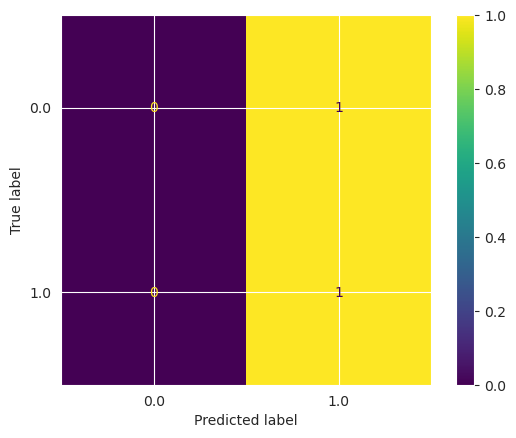

In [157]:
model_MLP = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(100, 50), max_iter=1000, random_state=3003)
model_MLP.fit(x_train_scaled, y_train)

y_pred = model_MLP.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
roc_cur = roc_curve(y_test, y_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_MLP.classes_)
disp.plot()

In [ ]:
modelResults(model_MLP, accuracy, f1, precision, recall, roc_auc, roc_cur, cm)

# Model evaluation
## Quick conclusion

In [180]:
resultsTable

,Model,Accuracy,F1 Score,Precision,Recall,ROC,ROC_AUC,cm
0,"LogisticRegression(class_weight='balanced', ma...",0.317881,0.413662,0.900826,0.268473,"([0.0, 0.2553191489361702, 1.0], [0.0, 0.26847...",0.506577,"[[0.7446808510638298, 0.2553191489361702], [0...."
1,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.317881,0.413662,0.900826,0.268473,"([0.0, 0.2553191489361702, 1.0], [0.0, 0.26847...",0.506577,"[[0.7446808510638298, 0.2553191489361702], [0...."
2,"(DecisionTreeClassifier(max_depth=100, max_fea...",0.317881,0.938967,0.896861,0.985222,"([0.0, 0.9787234042553191, 1.0], [0.0, 0.98522...",0.503249,"[[0.7446808510638298, 0.2553191489361702], [0...."
3,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.317881,0.945285,0.896247,1.000000,"([0.0, 1.0], [0.0, 1.0], [inf, 1.0])",0.500000,"[[0.7446808510638298, 0.2553191489361702], [0...."
4,KNeighborsClassifier(),0.874172,0.932704,0.895692,0.972906,"([0.0, 0.9787234042553191, 1.0], [0.0, 0.97290...",0.497091,"[[0.02127659574468085, 0.9787234042553191], [0..."
5,KNeighborsClassifier(),0.874172,0.932704,0.895692,0.972906,"([0.0, 0.9787234042553191, 1.0], [0.0, 0.97290...",0.497091,"[[0.02127659574468085, 0.9787234042553191], [0..."
6,KNeighborsClassifier(),0.874172,0.932704,0.895692,0.972906,"([0.0, 0.9787234042553191, 1.0], [0.0, 0.97290...",0.497091,"[[0.02127659574468085, 0.9787234042553191], [0..."
7,KNeighborsClassifier()5,0.874172,0.932704,0.895692,0.972906,"([0.0, 0.9787234042553191, 1.0], [0.0, 0.97290...",0.497091,"[[0.02127659574468085, 0.9787234042553191], [0..."
8,KNeighborsClassifier() n=5,0.874172,0.932704,0.895692,0.972906,"([0.0, 0.9787234042553191, 1.0], [0.0, 0.97290...",0.497091,"[[0.02127659574468085, 0.9787234042553191], [0..."
9,KNeighborsClassifier(n_neighbors=1) n=1,0.830022,0.906667,0.892601,0.921182,"([0.0, 0.9574468085106383, 1.0], [0.0, 0.92118...",0.481868,"[[0.0425531914893617, 0.9574468085106383], [0...."


In [181]:
best_model = resultsTable.loc[resultsTable['F1 Score'].idxmax()]

print(f"The model with the highest F1 score was {best_model['Model']} with an F1 score of {best_model['F1 Score']:.4f}")

The model with the highest F1 score was RandomForestClassifier(max_depth=5, random_state=3003) with an F1 score of 0.9453


## Graphs of numerical metrics
### Logarithmic scale

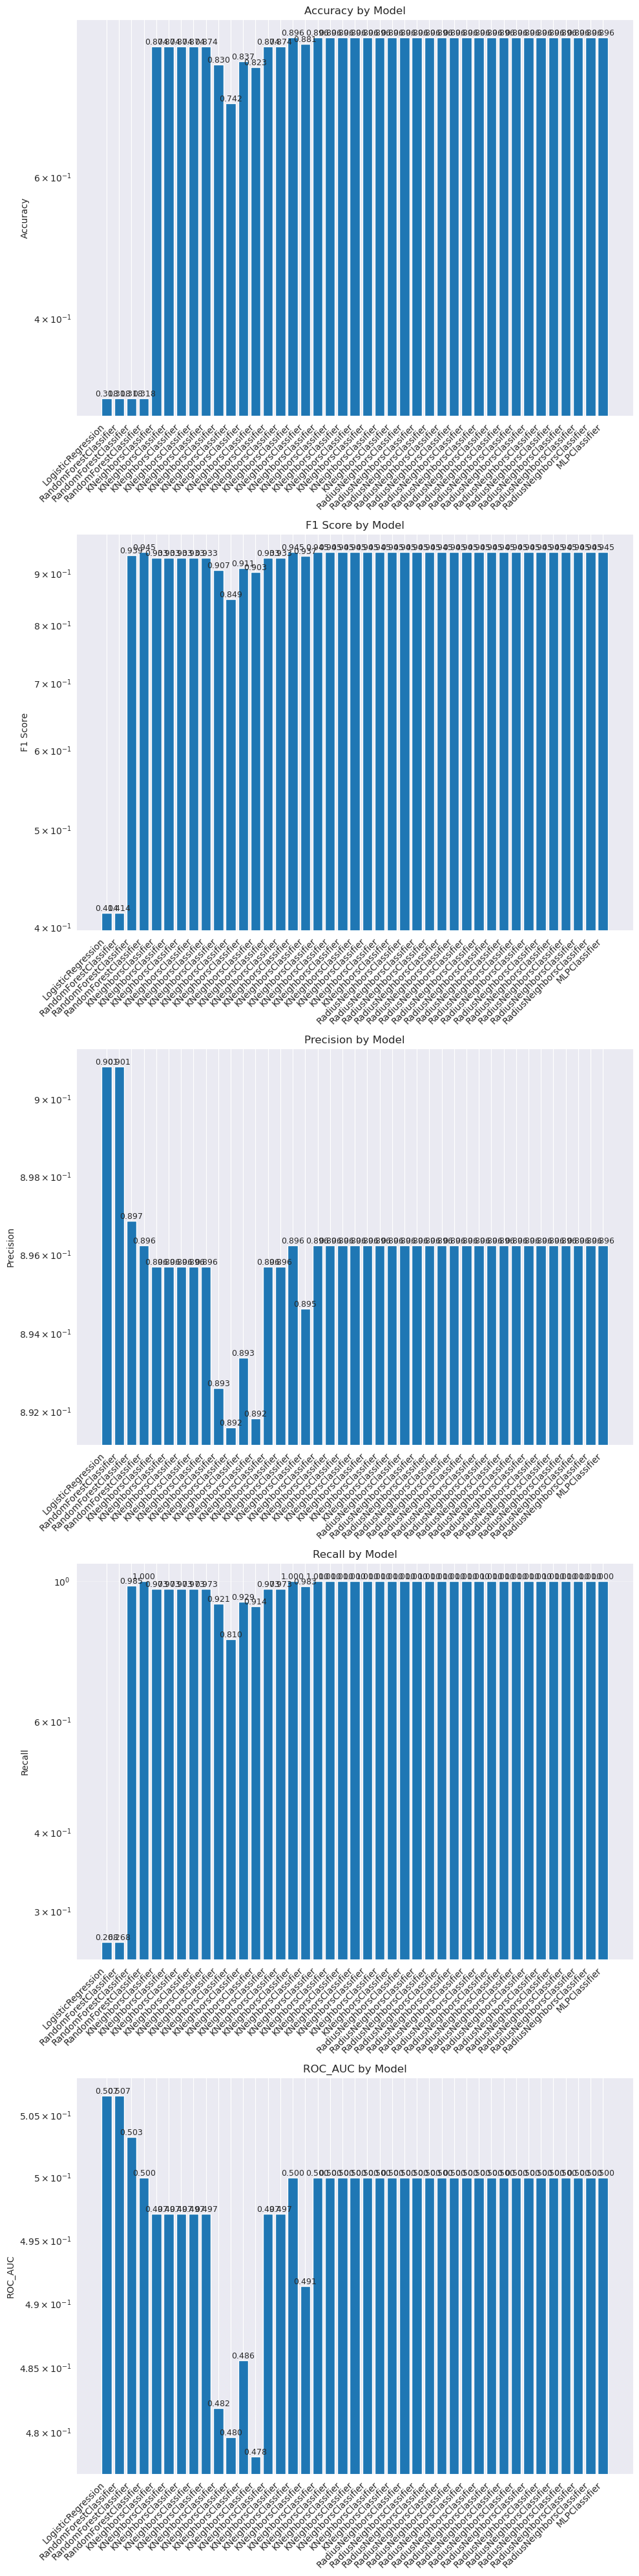

In [187]:
numeric_metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC_AUC']

model_labels = [str(model).split('(')[0] for model in resultsTable['Model']]

fig, axes = plt.subplots(len(numeric_metrics), 1, figsize=(10, len(numeric_metrics) * 8))

for i, col in enumerate(numeric_metrics):
    bars = axes[i].bar(range(len(resultsTable)), resultsTable[col])
    axes[i].set_xticks(range(len(resultsTable)))
    axes[i].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} by Model')
    axes[i].set_yscale('log')
    axes[i].grid(axis='y', alpha=0.3)

    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2., height,
                     f'{resultsTable[col].iloc[j]:.3f}',
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

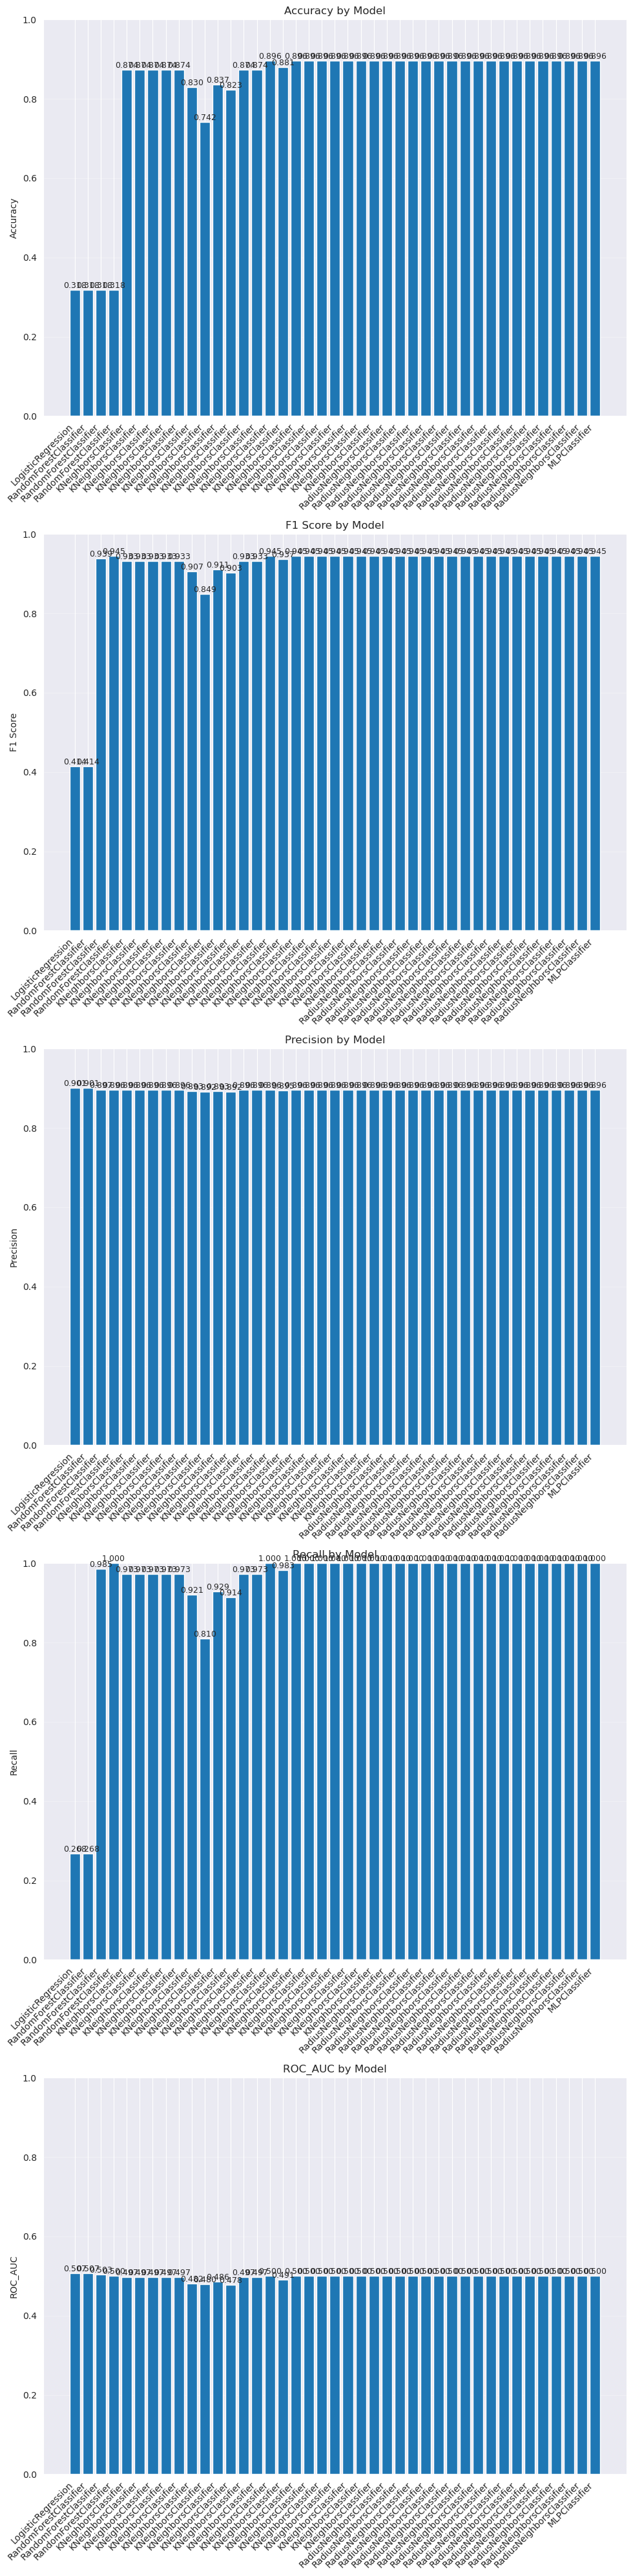

In [186]:
numeric_metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC_AUC']

model_labels = [str(model).split('(')[0] for model in resultsTable['Model']]

fig, axes = plt.subplots(len(numeric_metrics), 1, figsize=(10, len(numeric_metrics) * 8))

for i, col in enumerate(numeric_metrics):
    bars = axes[i].bar(range(len(resultsTable)), resultsTable[col])
    axes[i].set_xticks(range(len(resultsTable)))
    axes[i].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} by Model')
    axes[i].set_ylim(top=1)
    axes[i].grid(axis='y', alpha=0.3)

    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2., height,
                     f'{resultsTable[col].iloc[j]:.3f}',
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## ROC Curves

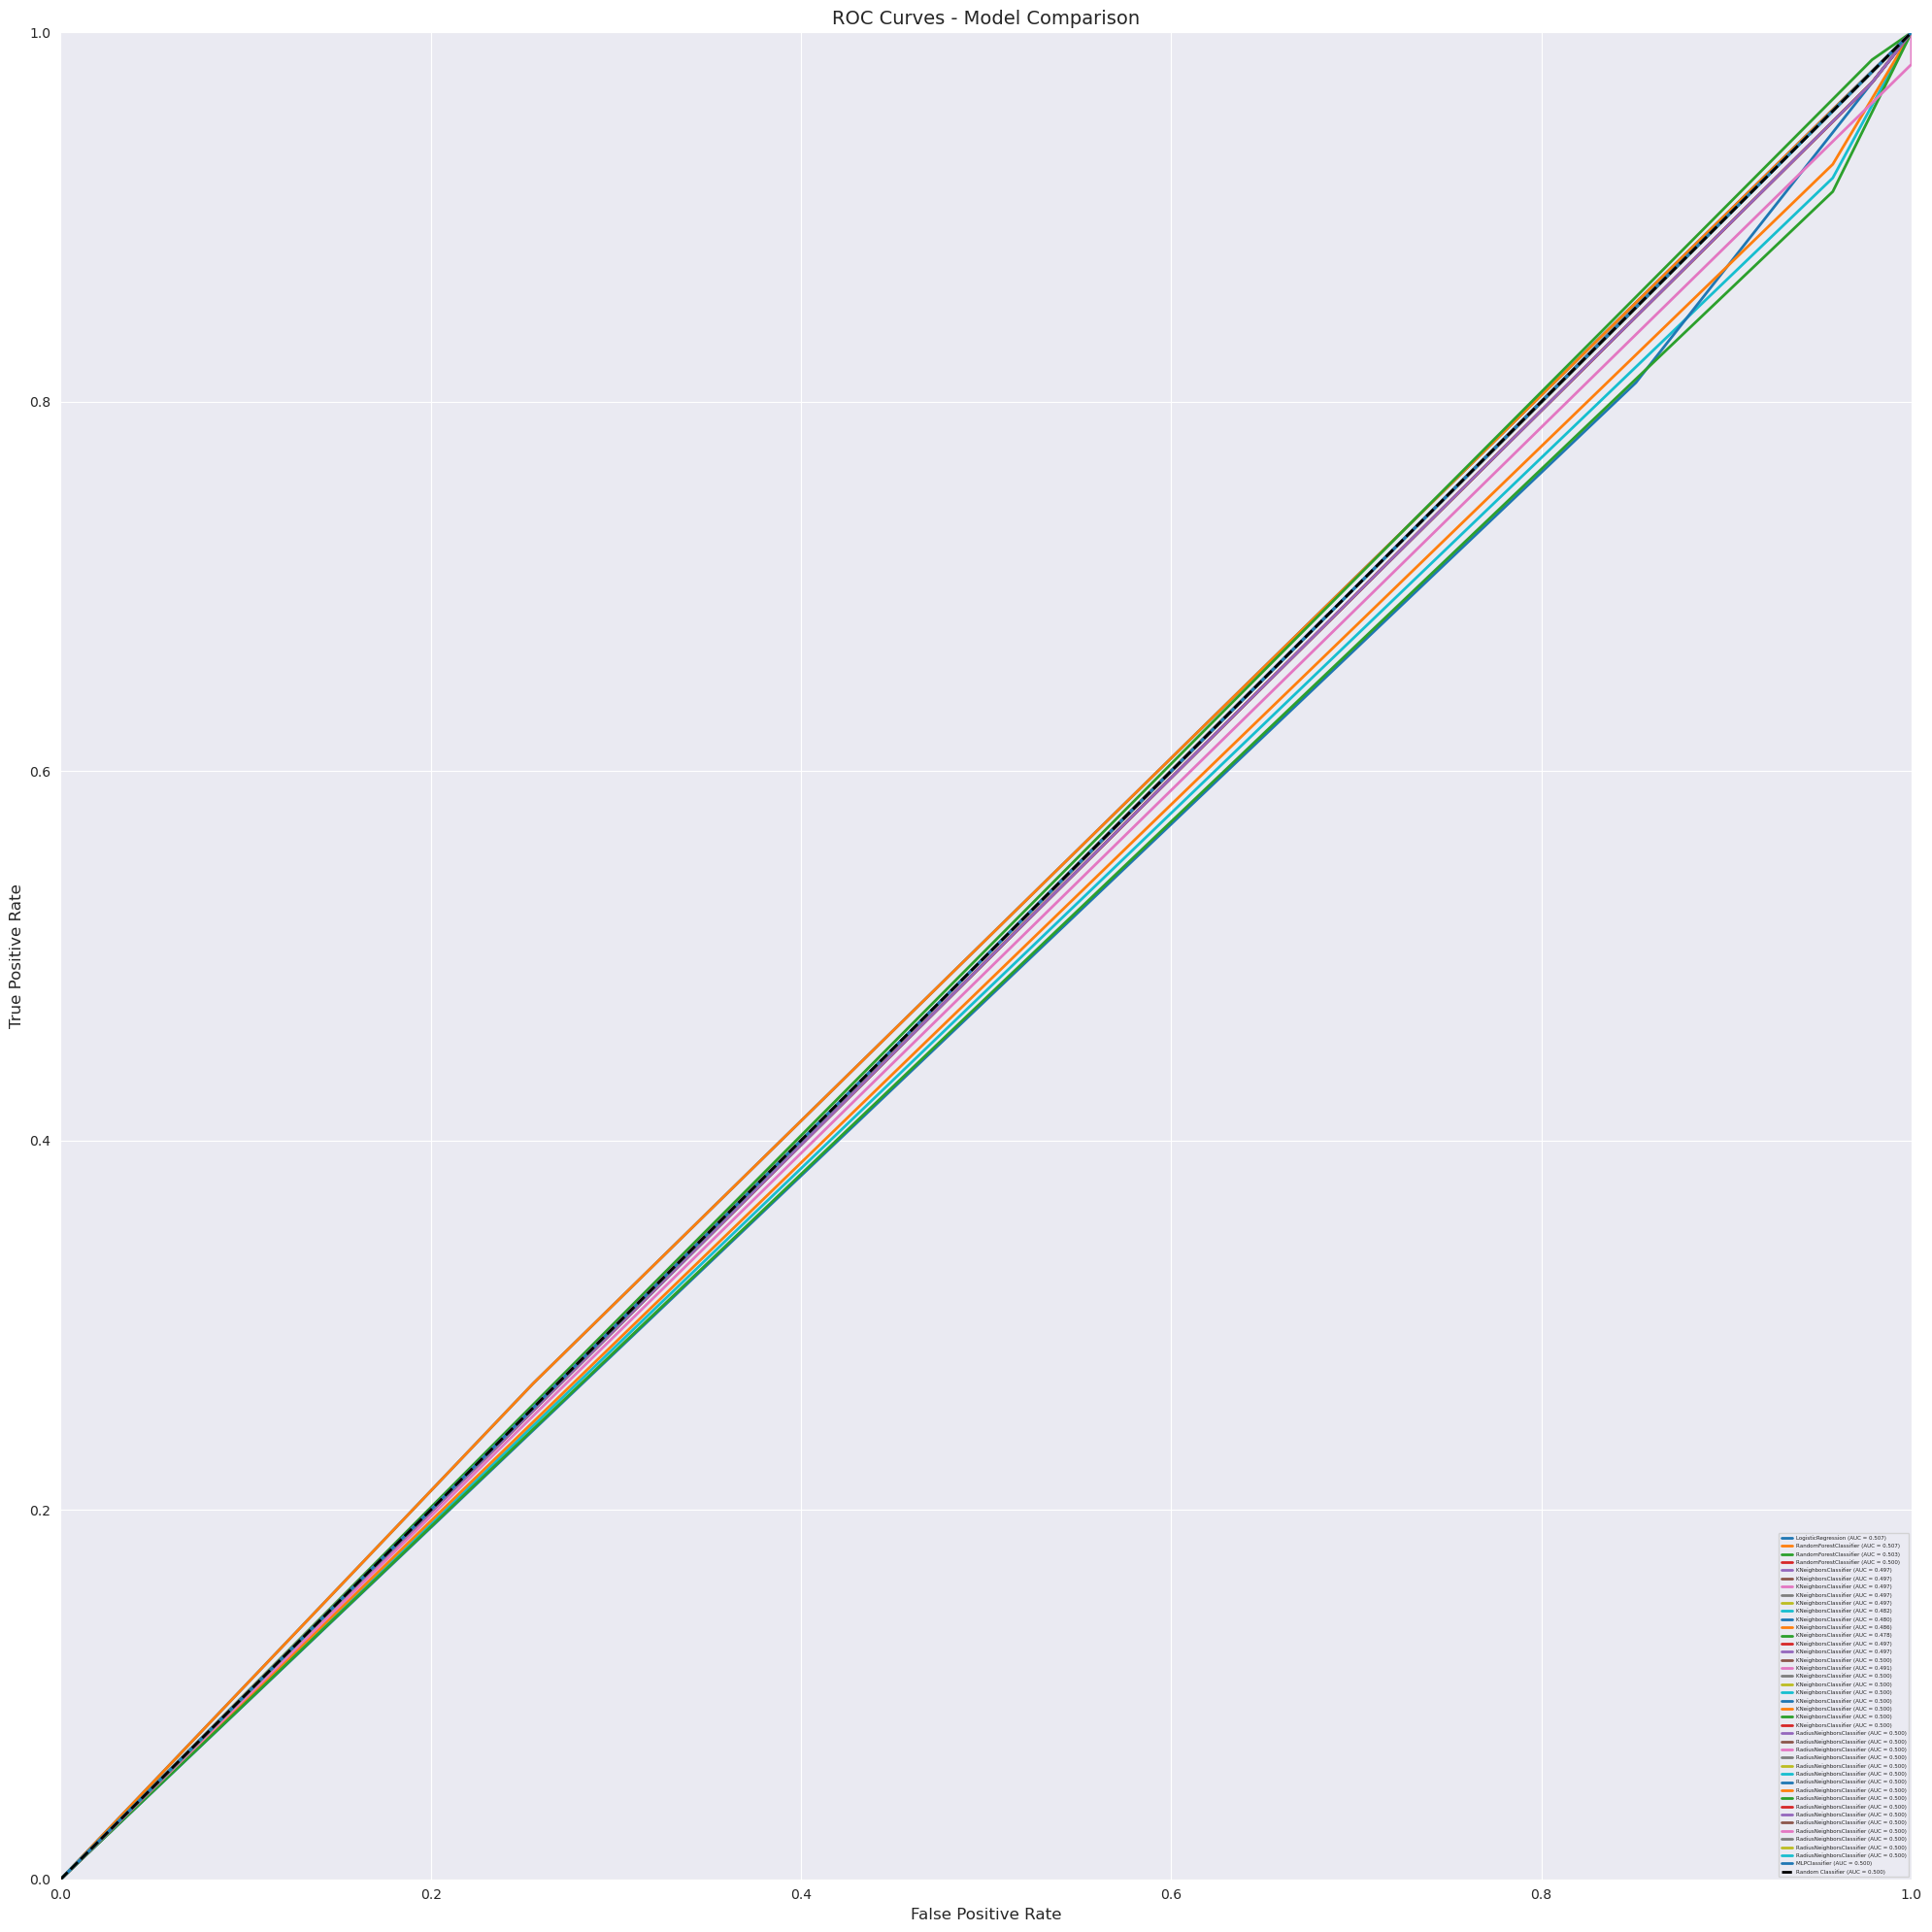

In [192]:
plt.figure(figsize=(20, 20))

for idx, row in resultsTable.iterrows():
    model_name = str(row['Model']).split('(')[0]
    fpr, tpr, thresholds = row['ROC']
    roc_auc = row['ROC_AUC']
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=4)
plt.grid(alpha=1)
plt.tight_layout()
plt.show()